# Data Processing

This script defines the methods and classes for extracting data from the resulting fast5 files that are generated from running DeepSimulator. The user provides the path to DeepSimulator and to the genomic sequence of interest stored in .fasta format. DeepSimulator can generate simulated signals at various resolutions, including ground truth. All extracted data is converted to original float32 values, filtered, and placed into the hdf5 file format.


## Modules and Libraries
To filter, we use the filtration code we developed in filters.ipynb. To obtain, we use import_ipynb. h5py is a python interface allowing h5 file writing. Our database will be created in the h5 format. All other dependencies are from filters.ipynb.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy import signal
from scipy.optimize import curve_fit
import math
from typing import Optional
import os
import h5py
import random

# Use filtration code developed in Filters.ipynb
import import_ipynb
from filters import Filters, TimesteppedFilters, ButterworthFilters

importing Jupyter notebook from filters.ipynb


## Electric Signal Reconstruction
.fast5 files store the raw electric current values in integer form to conserve space. This is done by using offset and scaling values which we can obtain and use to convert back to the original vales of raw electric current in pico-Amperes. This method handles this, given the path to the fast5 file and its name.

In [2]:
# Unpacks signals and restores to original values in pico-Amperes
def pA_convert(path_to_fast5, fname):
    os.system('h5ls -d %s/%s.fast5/Raw/Reads/Read_981/Signal >  %s/%s.data' % (path_to_fast5, 
                                                                               fname, 
                                                                               path_to_fast5, 
                                                                               fname))
    os.system('h5dump -a "/UniqueGlobalKey/channel_id/offset" %s/%s.fast5 > %s/shift.data' % (path_to_fast5,
                                                                                             fname, 
                                                                                             path_to_fast5))
    os.system('h5dump -a "/UniqueGlobalKey/channel_id/range" %s/%s.fast5 >> %s/shift.data' % (path_to_fast5,
                                                                                             fname, 
                                                                                             path_to_fast5))
    os.system('h5dump -a "/UniqueGlobalKey/channel_id/digitisation" %s/%s.fast5 >> %s/shift.data' % (path_to_fast5,
                                                                                                    fname, 
                                                                                                    path_to_fast5))
    raw = []

    with open('%s/%s.data' % (path_to_fast5, fname), 'r') as data:
        data.readline()
        data.readline()
        line = data.readline()
        while line != '':
            splitarr = line.split()
            splitarr.pop(0)
            last = splitarr[-1]
            for current in range(len(splitarr)):
                splitarr[current] = splitarr[current][:-1]
            raw.extend(splitarr)
            line = data.readline()
        raw[-1] = last
    
    # Get offset, range, and digitsation
    with open('%s/shift.data' % (path_to_fast5), 'r') as shift:
        for a in range(5):
            shift.readline()
        offsetLine = shift.readline()
        offsetArr = offsetLine.split()
        offsetArr.pop(0)
        offset = float(offsetArr[0])
    
        for b in range(8):
            shift.readline()
        rangeLine = shift.readline()
        rangeArr = rangeLine.split()
        rangeArr.pop(0)
        rang = float(rangeArr[0])
    
        for c in range(8):
            shift.readline()
        digLine = shift.readline()
        digArr = digLine.split()
        digArr.pop(0)
        dig = float(digArr[0])
    print('Offset:', offset, ', Range:', rang, ', Digitisation:', dig)

    os.system('rm %s/%s.data' % (path_to_fast5, fname))
    os.system('rm %s/shift.data' % (path_to_fast5))

    scale = rang/dig
    raw = np.array(raw, dtype=np.float32)

    signal = (raw + offset)*scale
    return signal

## Generating and Extracting Data
### Ground Truth Read
We need to generate a ground truth signal with no noise--essentially the results we would get if ONT's sequencing machines were ideal. The actual "perfect" option on DeepSimulator scales to the size of the sequence which is not ideal for comparison (due to some regions of data being "longer" once mapped to the correct size). Instead, the truth signal is generated manually by adding no Gaussian noise and using a frequency cutoff that is too high to affect results significantly. This is the signal we use to as the baseline to define a loss function against. 


### Noisy Read
To build a varied dataset, we want to generate signals with noise we can control. This signal's difference from the ground truth can be seen when we graph the first 500 measurements of both. The amount of Gaussian noise and the extent of cutting off higher frequencies can both be modified to the user's needs with the -e, -f, and -s parameters. Further information about DeepSimulator and its parameters can be found here: https://academic.oup.com/bioinformatics/article/36/8/2578/5698265#supplementary-data

In [3]:
# Object implementation so that reads can be generated several times with varying levels/types of noise
class genData:
    def __init__(self, path_to_deepsim, sequence, path_to_fasta):
        self.path_to_deepsim = path_to_deepsim
        self.sequence = sequence
        self.path_to_fasta = path_to_fasta
    
    # Generate truth read, convert back into pico-Amperes
    def truthRead(self):
        os.system('%s/deep_simulator.sh -i %s -e 0 -f 12000 -s 0 -n -1' % (self.path_to_deepsim,
                                                                           self.path_to_fasta))
        cwd = os.getcwd()
        PATH_TO_FAST5 = os.path.join(cwd, '%s_DeepSimu/fast5' % self.sequence)
        f = []
        for (dirpath, dirnames, filenames) in os.walk(PATH_TO_FAST5):
            f.extend(filenames)
            break
    
        truth = f[0][:-6]
        truthRead = pA_convert(PATH_TO_FAST5, truth)
        os.system('rm -r %s_DeepSimu' % self.sequence)
        return truthRead

    # Generate the noisy read to user's specification or use defaults, convert back to pico-Amperes
    def noisyRead(self, e=None, f=None, s=None):
        
        # Can only use custom noise if event_std (e), cutoff frequency (f), and signal_std (s) are all passed
        if (e is not None) and (f is not None) and (s is not None):
            os.system('%s/deep_simulator.sh -i %s -e %s -f %s -s %s -n -1' % (self.path_to_deepsim,
                                                                              self.path_to_fasta,
                                                                              e, f, s))
        else:
            #defaults: event_std = 1.0, cutoff frequency = 950 Hz, signal_std = 1.0
            os.system('%s/deep_simulator.sh -i %s -n -1' % (self.path_to_deepsim,
                                                            self.path_to_fasta))
        
        cwd = os.getcwd()
        PATH_TO_FAST5 = os.path.join(cwd, '%s_DeepSimu/fast5' % self.sequence)
        f = []
        for (dirpath, dirnames, filenames) in os.walk(PATH_TO_FAST5):
            f.extend(filenames)
            break

        noisy = f[0][:-6]
        noisyRead = pA_convert(PATH_TO_FAST5, noisy)
        os.system('rm -r %s_DeepSimu' % self.sequence)
        return noisyRead

## Data Treatment

After obtaining truth and noisy reads for a sequence (Human Chromosome 22 in this case) we run them through the optParams method. optParams segments the truth and noisy data into groups of 100 raw nanopore signals, randomly selects the user-specified number of segments to work with, runs them through all the circuit filters and only the Bandworth Low Pass filter, optimizes parameters, and returns 3 outputs.
- 'subNoisy' is an array containing all the segments that the computer randomly chose to filter
- 'label' is a list of arrays of tuples. The tuple contains the filter type and optimal parameters. The array holds the tuple for each filter type. Each array corresponds with one segment from subNoisy
- 'errArr' is an array that holds all the mean squared errors of the segments filtered with each filter against the ground truth segment.

The optParams function also allows the user to visualize all of the filtration against ground truth if specified. However, the 'visualize' parameter is optional and all the 3 outputs can be generated without. This allows us to filter large quantities of data. 

In [4]:
# Dividing reads into segments to filter individually
def segmentData(read):
    cutLen = 100 #currently fixed length; will later be an array telling length of each k-mer
    ncuts = (int) (len(read)/cutLen)
    
    cutArr = np.empty(ncuts) #defines indices to 'cut' the raw data; to be refined later (cwDTW_nano)
    start = 0
    for idx in range(cutArr.size):
        cutArr[idx] = (int) (start+cutLen)
        start = start+cutLen
    dataList =[] #list used for when sequence length becomes variable later
    startidx = 0
    for subsignal in range(ncuts):
        endidx = int(cutArr[subsignal])
        dataList.append(read[startidx:endidx])
        startidx = endidx
    dataList.append(noisyRead[startidx:])
    return dataList

# Runs samples through filters to choose optimal filters and parameters
def optParams(noisyRead, truthRead, nsamples, visualize=None): # 'visualize' defaults to False if not provided
    noisyList = segmentData(noisyRead)
    truthList = segmentData(truthRead)
    idxArr = np.empty(nsamples, dtype='int') #array of random indices
    
    # Only using nsamples of the original list, randomly sampled
    subNoisy = []
    subTruth = []
    
    # Assigning the same random samples to both subLists
    for n in range(nsamples):
        idxArr[n] = random.randint(0, len(noisyList))
        subNoisy.append(noisyList[idxArr[n]]) 
        subTruth.append(truthList[idxArr[n]])
    
    label = []
    errArr = np.empty([nsamples, 4])
    
    # Filtering each segment
    for sample in range(nsamples):    
        dspan = np.linspace(0, subNoisy[sample].size, subNoisy[sample].size)
        if visualize is True:
            plt.plot(dspan, subNoisy[sample], color='blue', label='Noisy Signal')
            plt.plot(dspan, subTruth[sample],'--', color='green', label='Ground Truth')
            plt.legend(loc='upper right')
            plt.margins(0.05, 0.4)
            plt.title('Unfiltered Signal and Truth')
            plt.show()
        
        # Frequency Domain representation of the noisy signal segment
        filterobj = Filters(dspan, subNoisy[sample])
        params = np.empty(3)
        params = filterobj.maxFreq(np.max(dspan))
        if visualize is True:
            print('Strongest frequency at:', params[3][0], 'Hz')
            filterobj.graphFFT(params[0], params[1], params[2])
        
        # Adding odd harmonics of largest signal to noisy data before filtering
        #superPositioned = filterobj.superPosition(params[3][0])
        #if visualize is True:
        #    print('Error with superpositioning', filterobj.relErr(superPositioned, subTruth[sample]))
        #    plt.plot(dspan, superPositioned, label='Filtered') #sqlowfilter[0].y[0,:]+
        #    plt.plot(dspan, subTruth[sample], '--',label='Truth')
        #    plt.legend(loc='upper right')
        #    plt.margins(0.05, 0.4)
        #    plt.title('Odd Harmonics Superimposed on (Bandworth Low Pass) Filtered Signal')
        #    plt.show()
        
        
        timestepped = TimesteppedFilters(dspan, subNoisy[sample]) # superPositioned if superPosition func used
        lowfilter = timestepped.optSolve(subTruth[sample], ftype='lowpass')
        highfilter = timestepped.optSolve(subTruth[sample], ftype='highpass')
        bandpassfilter = timestepped.optSolve(subTruth[sample], ftype='bandpass')
        
        if visualize is True:
            timestepped.graph(lowfilter, 'Low Pass', truth=subTruth[sample])
            print('Low Pass Err: ', timestepped.relErr(lowfilter[0].y[0,:], subTruth[sample]))
            timestepped.graph(highfilter, 'High Pass', truth=subTruth[sample])
            print('High Pass Err: ', timestepped.relErr(highfilter[0].y[0,:], subTruth[sample]))
            timestepped.graph(bandpassfilter, 'Band Pass', truth=subTruth[sample])
            print('Band Pass Err: ', timestepped.relErr(bandpassfilter[0].y[0,:], subTruth[sample]))
        
        butterworth = ButterworthFilters(dspan, subNoisy[sample])
        butterlow = butterworth.optSolve(10, subTruth[sample], ftype='lowpass')
        #butterhigh = butterworth.optSolve(10, subTruth[sample], ftype='highpass')
        #butterbpass = butterworth.optSolve(10, subTruth[sample], ftype='bandpass')
        #butterbstop = butterworth.optSolve(10, subTruth[sample], ftype='bandstop')
        if visualize is True:
            butterworth.graph(butterlow[0], butterlow[1], 'Low Pass', truth=subTruth[sample])
            print('Bandworth Low Pass Err: ', timestepped.relErr(butterlow[0], subTruth[sample]))
        
        errArr[sample][0] = timestepped.relErr(lowfilter[0].y[0,:], subTruth[sample])
        errArr[sample][1] = timestepped.relErr(highfilter[0].y[0,:], subTruth[sample])
        errArr[sample][2] = timestepped.relErr(bandpassfilter[0].y[0,:], subTruth[sample])
        errArr[sample][3] = butterworth.relErr(butterlow[0], subTruth[sample])
        #errArr[4] = butterworth.relErr(butterhigh[0], subTruth[sample])
        #errArr[4] = butterworth.relErr(butterbpass[0], subTruth[sample])
        #errArr[5] = butterworth.relErr(butterbstop[0], subTruth[sample])
        
        label.append([['Lowpass', lowfilter[1]], 
                        ['Highpass', highfilter[1]], 
                        ['Bandpass', bandpassfilter[1]], 
                        ['Butterworth Lowpass', butterlow[1]]]) 
    
    return subNoisy, label, errArr

# User Interface

The code below demonstrates what the user provides to generate the labels metadata and the segmented data. This allows users to easily generate data at various resolutions. 

## Example Implementation on Human Chromosome 22
The object-oriented approach to generating data lets us generate a truth signal only once, then build with a variety of noise to append to a database. The user only needs to provide the path to DeepSimulator and the sequence name of the .fasta file used. Note that when custom noise is used, **all** of the optional parameters must be provided. 

In [5]:
# Creating ground truth read and noisy read for 1M base-pairs on Human Chromosome 22
if __name__ == '__main__':
    PATH_TO_DEEPSIM = '/Users/aaronphilip/ScienceFair/projects/NanoporeSequencingFiltering/DeepSimulator'
    SEQUENCE = 'artificial_human_chr22'
    PATH_TO_FASTA = os.path.join(PATH_TO_DEEPSIM, 'example/%s.fasta' % SEQUENCE)
    # User is recommended to place .fasta files in subdirectory of DeepSimulator; eg. 'example'

    humanChr22 = genData(PATH_TO_DEEPSIM, SEQUENCE, PATH_TO_FASTA)
    truthRead = humanChr22.truthRead()
    noisyRead = humanChr22.noisyRead()

Offset: 37.0 , Range: 1368.36 , Digitisation: 8192.0
Offset: 37.0 , Range: 1368.36 , Digitisation: 8192.0


## Visualizing Data
The cell below is purely for visualization purposes; the user doesn't need to write any of the following. These plots help explain why mapping a "perfect" signal with a smaller size is difficult. It is easily apparent that some plateaus are brief in occurance while other areas' plateaus have longer periods.
In the future, we may use Dynamic Time Warping tools like cwDTW_nano to perform such mapping to reduce some error, but for now, keeping a high cutoff frequency is sufficient. 

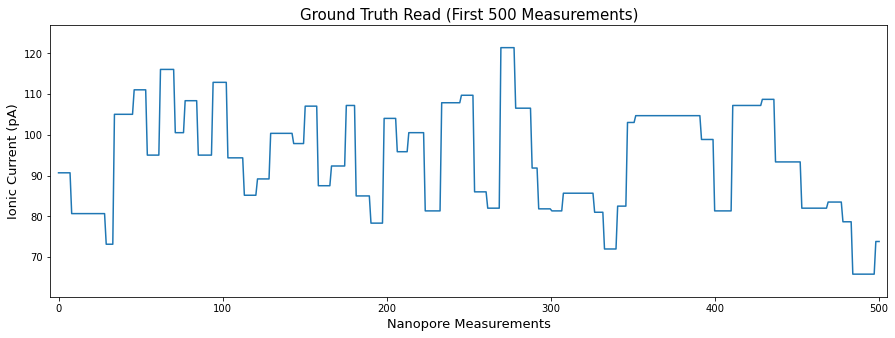

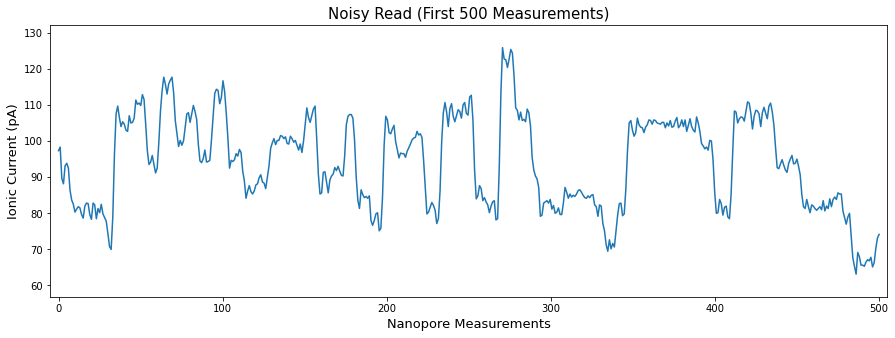

In [6]:
# Graphing ground truth read and noisy tread
if __name__ == '__main__': 
    plt.figure(figsize=(15, 5))
    plt.plot(np.linspace(0, 500, 500), truthRead[:500])
    plt.title('Ground Truth Read (First 500 Measurements)', fontsize='15')
    plt.xlabel('Nanopore Measurements', fontsize='13')
    plt.ylabel('Ionic Current (pA)', fontsize='13')
    plt.margins(0.01, 0.1)
    plt.show()

    plt.figure(figsize=(15, 5))
    plt.plot(np.linspace(0, 500, 500), noisyRead[0:500])
    plt.title('Noisy Read (First 500 Measurements)', fontsize='15')
    plt.xlabel('Nanopore Measurements', fontsize='13')
    plt.ylabel('Ionic Current (pA)', fontsize='13')
    plt.margins(0.01, 0.1)
    plt.show()

## Filtering Segments

The actual filtering takes place largely "under the hood" so very little user input is required after generating truth and noisy reads. 

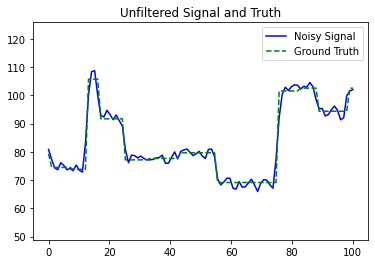

Strongest frequency at: 0.01 Hz


/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


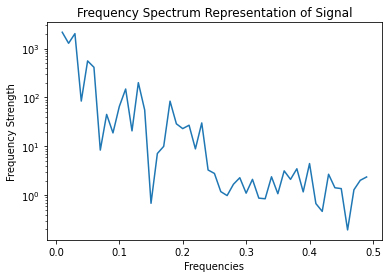

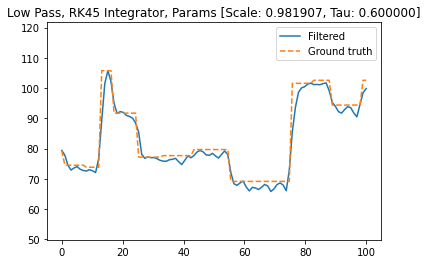

Low Pass Err:  9.915765233300045


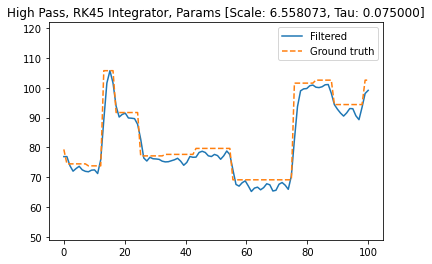

High Pass Err:  12.514861453569777


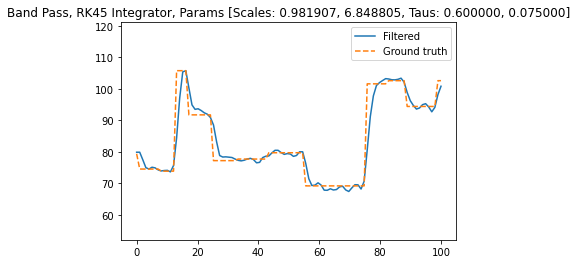

Band Pass Err:  15.411551941447193


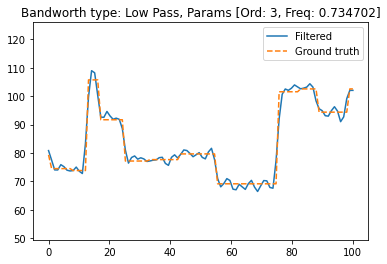

Bandworth Low Pass Err:  5.4088484053625345


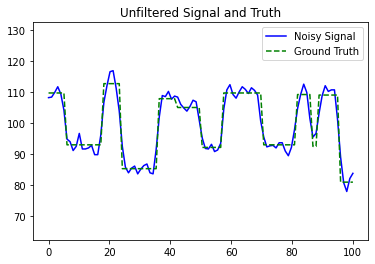

Strongest frequency at: 0.05 Hz


/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


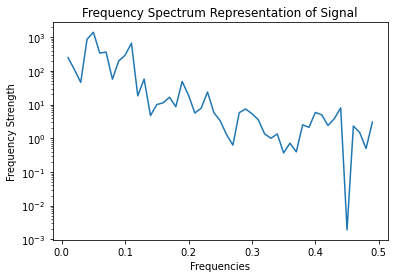

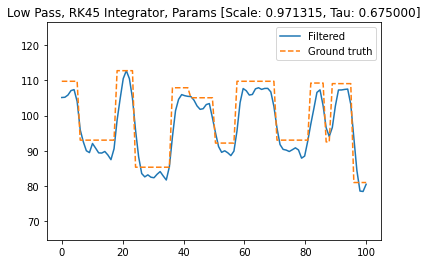

Low Pass Err:  22.57268698210289


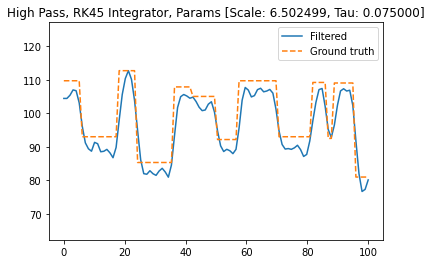

High Pass Err:  24.865378376505628


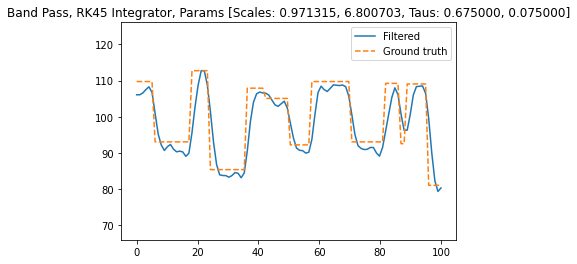

Band Pass Err:  29.513985883577565


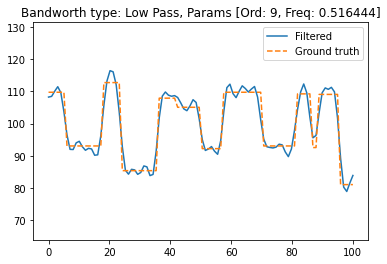

Bandworth Low Pass Err:  9.13731517339554


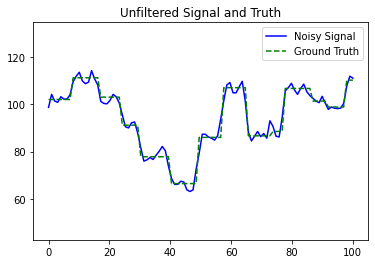

Strongest frequency at: 0.01 Hz


/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


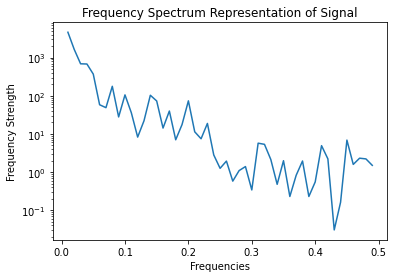

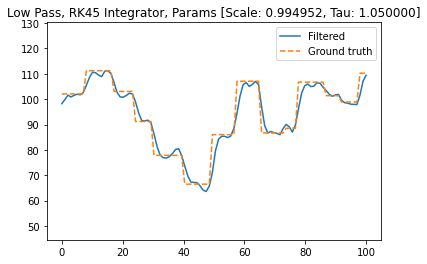

Low Pass Err:  11.834382778418238


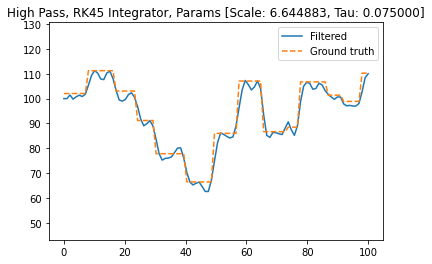

High Pass Err:  8.594900694455976


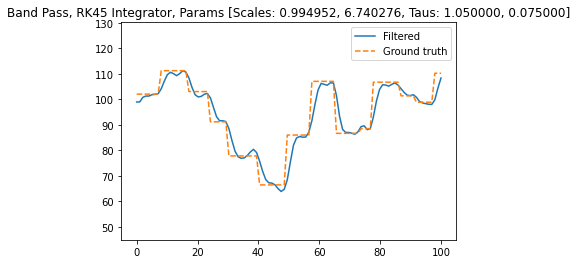

Band Pass Err:  20.243763586039446


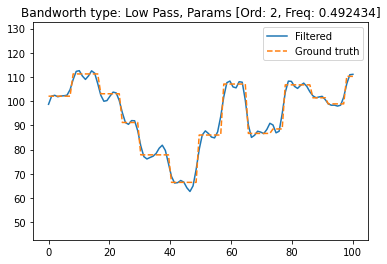

Bandworth Low Pass Err:  5.316164105987445
[[['Lowpass', array([0.98190717, 0.6       ])], ['Highpass', array([6.55807253, 0.075     ])], ['Bandpass', array([0.98190717, 0.6       , 6.84880538, 0.075     ])], ['Butterworth Lowpass', array([3.        , 0.73470207])]], [['Lowpass', array([0.97131506, 0.675     ])], ['Highpass', array([6.50249931, 0.075     ])], ['Bandpass', array([0.97131506, 0.675     , 6.80070313, 0.075     ])], ['Butterworth Lowpass', array([9.        , 0.51644405])]], [['Lowpass', array([0.99495246, 1.05      ])], ['Highpass', array([6.64488325, 0.075     ])], ['Bandpass', array([0.99495246, 1.05      , 6.74027559, 0.075     ])], ['Butterworth Lowpass', array([2.        , 0.49243392])]]] [[ 9.91576523 12.51486145 15.41155194  5.40884841]
 [22.57268698 24.86537838 29.51398588  9.13731517]
 [11.83438278  8.59490069 20.24376359  5.31616411]]


In [7]:
if __name__ == '__main__':
    data, labels, errors = optParams(noisyRead, truthRead, 3, visualize=True)
    print(labels, errors)